In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [2]:
train = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/train.csv')
test = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/test.csv')
era = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/era.csv')
sample_submission = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/sample_submission.csv')

In [3]:
#categorical変数抽出
cat_cols = [c for c in test.columns if train[c].dtype == np.object]

# numerical変数抽出
num_cols = [c for c in test.columns if train[c].dtype != np.object]

#目的変数抽出
target_col = 'is_kokuhou'

print(cat_cols)
print(num_cols)
print(target_col)

['棟名', '種別2', '国', '時代', '都道府県 ※美工品は「所有者住所（所在都道府県）」', '所在地', '保管施設の名称', '所有者名', '管理団体又は責任者']
['緯度', '経度']
is_kokuhou


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [4]:
# target encoding

# kf = KFold(4)
# kf = KFold(4, groups=train.categorical)　#GroupKFold
kf = StratifiedKFold(5, shuffle=True, random_state=42531) #StratifiedKFold

# Target encoding with K-fold
# te = TargetEncoder(kf.split(train))
# te = TargetEncoder(kf.split(train)) #GroupKFold
te = TargetEncoder(kf.split(train, train[target_col])) #StratifiedKFold

# use fit/fit_transform to train data, then apply transform to test data
train.loc[:, cat_cols] = te.fit_transform(train[cat_cols], train[target_col])
test.loc[:, cat_cols] = te.transform(test[cat_cols])

In [5]:
# 欠損値を埋める
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [16]:
train.head()

,名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度,is_kokuhou
0,泉布観,0.086341,0.018656,0.050689,3.759398e-03,0.041263,0.074702,0.067246,0.092894,0.074234,34.69811,135.5214,0
1,絹本著色准胝仏母像,0.087930,0.091445,0.081048,8.286252e-02,0.101900,0.082786,0.069094,0.154884,0.074074,-1.00000,-1.0000,0
2,石上神宮拝殿,0.086341,0.136364,0.050689,3.719224e-01,0.153333,0.074702,0.067246,0.074702,0.074234,34.59780,135.8520,1
3,剣〈銘真守（備前）／〉,0.087183,0.110973,0.081824,8.699809e-02,0.101848,0.080018,0.066914,0.144170,0.107958,-1.00000,-1.0000,0
4,旧新町紡績所,0.074702,0.000008,0.047437,8.493954e-13,0.028203,0.064105,0.066914,0.064105,0.073498,36.27766,139.1003,0


In [6]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': 500,
    'verbose': 1,
    'min_samples_leaf': 10,
    'random_state': 42531
}

result = run_experiment(
    params,
    train[num_cols + cat_cols],
    train[target_col],
    test[num_cols + cat_cols],
    cv=StratifiedKFold(5, shuffle=True, random_state=42531), # cv=4,
    #groups = train.book_id,
    #categorical_feature=["user_id","book_id"],→これLGBM用？
    algorithm_type=RandomForestClassifier
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [7]:
print(result.metrics) # Evalulation metrics for each fold

[0.7580756843800321, 0.7744524959742352, 0.8167028985507246, 0.7878663446054751, 0.8483137999537262, 0.7922483266676503]


In [8]:
print(result.metrics) # Evalulation metrics for each fold

[0.759440418679549, 0.7839009661835747, 0.8051127214170692, 0.7867914653784219, 0.8461716437558341, 0.7947945307645299]


In [8]:
result.importance     # Feature importance for each fold

[]

In [10]:
print(result.test_prediction)  # Test prediction in numpy array
print(result.oof_prediction)   # Out-of-fold prediction in numpy array

[0.00915403 0.14843221 0.197659   ... 0.22420422 0.05093357 0.0061907 ]
[0.02401811 0.27328429 0.33193874 ... 0.05426757 0.27141531 0.0583067 ]


In [11]:
train[target_col].to_numpy()

array([0, 0, 1, ..., 0, 0, 0])

In [12]:
# データ全体のF1スコアを計算 & 閾値の最適化
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        score = f1_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# 例として使用するデータ（実際にはモデルからの予測値と実際のラベルを使用）
y_true = train[target_col].values
y_scores = result.oof_prediction

best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best threshold: 0.19191919191919193
Best F1 Score: 0.3309982486865149


In [13]:
# 閾値を超える確率を持つ要素を1に、それ以外を0に変換
y_pred = (result.test_prediction > best_threshold).astype(int)
print(y_pred)
print(y_pred.shape)

[0 0 1 ... 1 0 0]
(10065,)


In [14]:
sample_submission['is_kokuhou'] = y_pred
sample_submission

,is_kokuhou
0,0
1,0
2,1
3,0
4,0
...,...
10060,0
10061,0
10062,1
10063,0


In [17]:
sample_submission["is_kokuhou"].value_counts()

0    9137
1     928
Name: is_kokuhou, dtype: int64

In [18]:
sample_submission.to_csv('RF_ver1.csv', index=False)

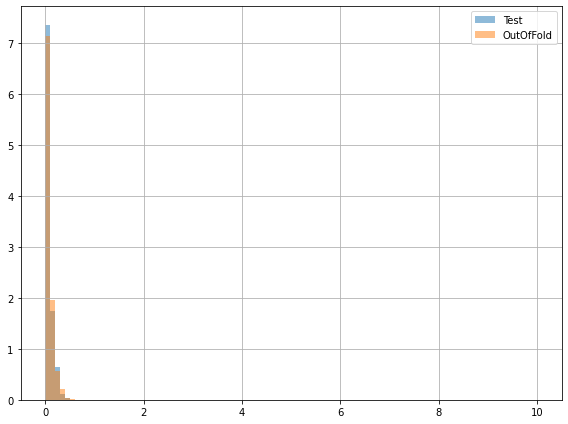

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(result.test_prediction, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(result.oof_prediction, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()